In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, chi2_contingency
from sklearn.preprocessing import OneHotEncoder
import uuid
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import pearsonr, pointbiserialr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV
import os
import subprocess
from sklearn.tree import export_graphviz
import graphviz
import json
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
# 1. Muat dataset
df = pd.read_csv('/content/data_faringitis.csv', sep=';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   no                 128 non-null    int64  
 1   Usia               128 non-null    int64  
 2   Jenis Kelamin      128 non-null    int64  
 3   Demam              128 non-null    int64  
 4   Nyeri Menelan      128 non-null    int64  
 5   Sakit Tenggorokan  128 non-null    int64  
 6   Kepala Pusing      128 non-null    int64  
 7   Batuk              128 non-null    int64  
 8   Pilek              128 non-null    int64  
 9   Durasi Gejala      106 non-null    float64
 10  Suhu               128 non-null    float64
 11  Sistolik           128 non-null    int64  
 12  Diastolik          128 non-null    int64  
 13  Nadi               128 non-null    int64  
 14  Pernafasan         128 non-null    int64  
 15  Berat Badan        128 non-null    float64
 16  Tinggi Badan       128 non

In [ ]:
df.isnull().sum()


,0
no,0
Usia,0
Jenis Kelamin,0
Demam,0
Nyeri Menelan,0
Sakit Tenggorokan,0
Kepala Pusing,0
Batuk,0
Pilek,0
Durasi Gejala,22


In [ ]:
# median imputation
imputer = SimpleImputer(strategy='median')
df['Durasi Gejala'] = imputer.fit_transform(df[['Durasi Gejala']])
median_value = df['Durasi Gejala'].median()
print(f"Median Durasi Gejala: {median_value}")

Median Durasi Gejala: 3.0


In [ ]:
missing_values = df.isnull().sum().reset_index()
missing_values.columns = ['Kolom', 'Jumlah Nilai Kosong']
missing_values = missing_values[missing_values['Jumlah Nilai Kosong'] >= 0]  # Opsional: hanya tampilkan kolom yang punya missing
missing_values = missing_values.sort_values(by='Jumlah Nilai Kosong', ascending=False)

print(missing_values.to_string(index=False))

            Kolom  Jumlah Nilai Kosong
               no                    0
             Usia                    0
    Jenis Kelamin                    0
            Demam                    0
    Nyeri Menelan                    0
Sakit Tenggorokan                    0
    Kepala Pusing                    0
            Batuk                    0
            Pilek                    0
    Durasi Gejala                    0
             Suhu                    0
         Sistolik                    0
        Diastolik                    0
             Nadi                    0
       Pernafasan                    0
      Berat Badan                    0
     Tinggi Badan                    0
        Diagnosis                    0
      Amoxicillin                    0
      Paracetamol                    0
 N-Acetylcysteine                    0
       Cetirizine                    0
        Vitamin C                    0
       Prednisone                    0
         Ambroxol        

In [ ]:
# Menghapus kolom 'no'
if 'no' in df.columns:
    df = df.drop(columns=['no'])

In [ ]:
# Periksa kualitas data
numerics_cols = ['Usia', 'Suhu', 'Durasi Gejala', 'Sistolik', 'Diastolik', 'Nadi', 'Pernafasan', 'Berat Badan', 'Tinggi Badan']
biner_columns = ['Jenis Kelamin', 'Demam', 'Nyeri Menelan', 'Sakit Tenggorokan', 'Kepala Pusing', 'Batuk', 'Pilek']
categorical_columns = ['Diagnosis']
print("\nStatistik Deskriptif:")
print(df[numerics_cols].describe())
print("\nMissing Values:")
print(df[numerics_cols + biner_columns + categorical_columns].isnull().sum())



Statistik Deskriptif:
             Usia       Suhu  Durasi Gejala    Sistolik   Diastolik  \
count  128.000000  128.00000     128.000000  128.000000  128.000000   
mean    26.281250   36.36875       4.398438  114.359375   75.148438   
std     15.379676    0.49688       4.692664   18.294930   11.352678   
min      3.000000   36.00000       1.000000   82.000000   50.000000   
25%     14.750000   36.00000       2.000000  100.000000   67.000000   
50%     24.500000   36.00000       3.000000  116.000000   75.000000   
75%     35.000000   36.70000       5.000000  125.000000   81.000000   
max     69.000000   38.30000      30.000000  167.000000  110.000000   

             Nadi  Pernafasan  Berat Badan  Tinggi Badan  
count  128.000000  128.000000   128.000000    128.000000  
mean    72.914062   16.421875    50.775781    150.756250  
std      7.261187    1.289628    18.422059     18.827425  
min     65.000000   16.000000    11.900000     93.000000  
25%     70.000000   16.000000    42.750000

In [ ]:

# Menangani kolom kategorikal (Diagnosis)
print("\nKolom kategorikal yang akan diencode :", categorical_columns)

# Menampilkan daftar dan frekuensinya sebelum One-Hot ---
print("\nDaftar kategori pada kolom 'Diagnosis':")
print(df[categorical_columns[0]].unique())

print("\nJumlah masing-masing diagnosis sebelum One-Hot:")
print(df[categorical_columns[0]].value_counts())

# -----------------------------------------------------------------------------

encoder = OneHotEncoder(sparse_output=False, drop=None, handle_unknown='ignore')
encoded_data = encoder.fit_transform(df[categorical_columns])
encoded_columns = encoder.get_feature_names_out(categorical_columns)
df_encoded = pd.DataFrame(encoded_data, columns=encoded_columns, index=df.index)
df = df.drop(columns=categorical_columns)
df = pd.concat([df, df_encoded], axis=1)

diagnosis_columns = [col for col in encoded_columns if col.startswith('Diagnosis_')]
print("\nKolom Diagnosis terenkode :", diagnosis_columns)

# --- Tampilkan frekuensi masing-masing kolom One-Hot ---
print("\nJumlah masing-masing diagnosis setelah One-Hot:")
for col in diagnosis_columns:
    print(f"{col} : {df[col].sum()}")



Kolom kategorikal yang akan diencode : ['Diagnosis']

Daftar kategori pada kolom 'Diagnosis':
['J02' 'J02.0' 'J02.8' 'J02.9']

Jumlah masing-masing diagnosis sebelum One-Hot:
Diagnosis
J02      96
J02.0    23
J02.8     5
J02.9     4
Name: count, dtype: int64

Kolom Diagnosis terenkode : ['Diagnosis_J02', 'Diagnosis_J02.0', 'Diagnosis_J02.8', 'Diagnosis_J02.9']

Jumlah masing-masing diagnosis setelah One-Hot:
Diagnosis_J02 : 96.0
Diagnosis_J02.0 : 23.0
Diagnosis_J02.8 : 5.0
Diagnosis_J02.9 : 4.0


In [ ]:
print("Kolom yang tersedia :", df.columns)


Kolom yang tersedia : Index(['Usia', 'Jenis Kelamin', 'Demam', 'Nyeri Menelan', 'Sakit Tenggorokan',
       'Kepala Pusing', 'Batuk', 'Pilek', 'Durasi Gejala', 'Suhu', 'Sistolik',
       'Diastolik', 'Nadi', 'Pernafasan', 'Berat Badan', 'Tinggi Badan',
       'Amoxicillin', 'Paracetamol', 'N-Acetylcysteine', 'Cetirizine',
       'Vitamin C', 'Prednisone', 'Ambroxol', 'Ibuprofen', 'Diagnosis_J02',
       'Diagnosis_J02.0', 'Diagnosis_J02.8', 'Diagnosis_J02.9'],
      dtype='object')


korelasi antar fitur dan penggabungan fitur

In [ ]:
print("\nKorelasi antar-fitur numerik:")
corr_matrix = df[numerics_cols].corr()
print(corr_matrix)
# Identifikasi pasangan dengan korelasi tinggi (|r| > 0.7)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))
print("\nPasangan dengan korelasi |r| > 0.7:")
for pair in high_corr_pairs:
    print(f"{pair[0]} vs {pair[1]}: r = {pair[2]:.3f}")

# Gabungkan fitur: IMT dan MAP
# IMT = Berat Badan (kg) / (Tinggi Badan (m))^2
df['IMT'] = df['Berat Badan'] / ((df['Tinggi Badan'] / 100) ** 2)
# MAP = (Sistolik + 2 * Diastolik) / 3
df['MAP'] = (df['Sistolik'] + 2 * df['Diastolik']) / 3

# Hapus kolom redundan
redundant_cols = ['Berat Badan', 'Tinggi Badan', 'Sistolik', 'Diastolik']
df = df.drop(columns=redundant_cols)
print("\nKolom setelah menghapus redundansi:", df.columns)


Korelasi antar-fitur numerik:
                   Usia      Suhu  Durasi Gejala  Sistolik  Diastolik  \
Usia           1.000000 -0.071586       0.136012  0.526671   0.321303   
Suhu          -0.071586  1.000000      -0.092212 -0.202050  -0.256291   
Durasi Gejala  0.136012 -0.092212       1.000000  0.094529  -0.029349   
Sistolik       0.526671 -0.202050       0.094529  1.000000   0.706254   
Diastolik      0.321303 -0.256291      -0.029349  0.706254   1.000000   
Nadi           0.097520 -0.085646       0.009101  0.043741   0.097968   
Pernafasan    -0.015557 -0.082483       0.216614  0.049257   0.067219   
Berat Badan    0.459336 -0.250216       0.236200  0.533234   0.435389   
Tinggi Badan   0.502391 -0.182138       0.078885  0.424813   0.298890   

                   Nadi  Pernafasan  Berat Badan  Tinggi Badan  
Usia           0.097520   -0.015557     0.459336      0.502391  
Suhu          -0.085646   -0.082483    -0.250216     -0.182138  
Durasi Gejala  0.009101    0.216614     0.2

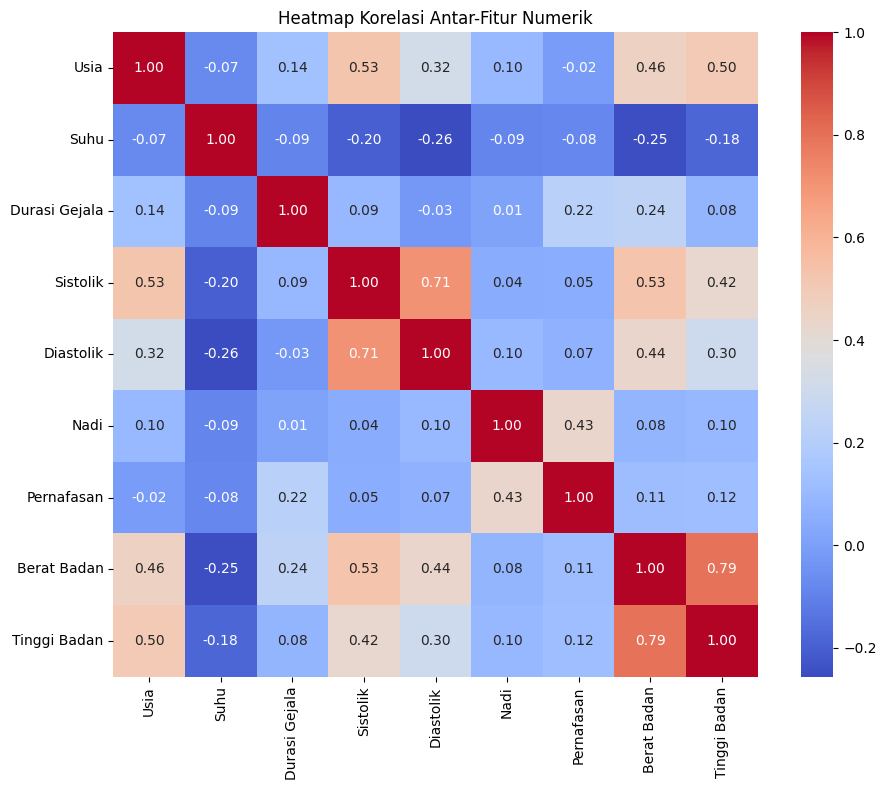

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

#Visualisasi korelasi antar fitur numerik (semua)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Heatmap Korelasi Antar-Fitur Numerik")
plt.tight_layout()
plt.show()


cek distirbusi label

In [ ]:
# Definisi kolom label (obat)
label_columns = ['Amoxicillin', 'Paracetamol', 'N-Acetylcysteine', 'Cetirizine', 'Vitamin C', 'Prednisone', 'Ambroxol', 'Ibuprofen']

# Distribusi label
print("\nDistribusi Label:")
distributions = {}
for label in label_columns:
    print(f"\n{label}:")
    distribution = df[label].value_counts(normalize=True).sort_index()
    print(distribution)
    distributions[label] = distribution

# Simpan distribusi ke file CSV
dist_df = pd.DataFrame(distributions).fillna(0)
dist_df.to_csv('label_distribution.csv', sep=';')
print("\nDistribusi label disimpan sebagai 'label_distribution.csv'")


Distribusi Label:

Amoxicillin:
Amoxicillin
0    0.40625
1    0.59375
Name: proportion, dtype: float64

Paracetamol:
Paracetamol
0    0.28125
1    0.71875
Name: proportion, dtype: float64

N-Acetylcysteine:
N-Acetylcysteine
0    0.375
1    0.625
Name: proportion, dtype: float64

Cetirizine:
Cetirizine
0    0.242188
1    0.757812
Name: proportion, dtype: float64

Vitamin C:
Vitamin C
0    0.671875
1    0.328125
Name: proportion, dtype: float64

Prednisone:
Prednisone
0    0.835938
1    0.164062
Name: proportion, dtype: float64

Ambroxol:
Ambroxol
0    0.796875
1    0.203125
Name: proportion, dtype: float64

Ibuprofen:
Ibuprofen
0    0.929688
1    0.070312
Name: proportion, dtype: float64

Distribusi label disimpan sebagai 'label_distribution.csv'


dilter pasien dengan ≥3 obat

In [ ]:
df['Jumlah Obat'] = df[label_columns].sum(axis=1)
print(df['Jumlah Obat'].value_counts().sort_index())

Jumlah Obat
1     1
2    11
3    52
4    56
5     8
Name: count, dtype: int64


In [ ]:
# Definisi kolom label
label_columns = ['Amoxicillin', 'Paracetamol', 'N-Acetylcysteine', 'Cetirizine',
                 'Vitamin C', 'Prednisone', 'Ambroxol', 'Ibuprofen']

# Filter pasien dengan ≥3 obat
df['Jumlah Obat'] = df[label_columns].sum(axis=1)
df_filtered = df[df['Jumlah Obat'] >= 3].drop(columns=['Jumlah Obat'])

print(f"Jumlah pasien setelah filter (≥3 obat): {len(df_filtered)} pasien")

distribusi = df_filtered[label_columns].sum(axis=1).value_counts().sort_index().reset_index()
distribusi.columns = ['Jumlah Obat', 'Jumlah Pasien']
print("\nDistribusi Jumlah Obat:")
print(distribusi.to_string(index=False))

# Redefinisikan feature_columns setelah filtering
feature_columns = [col for col in df_filtered.columns if col not in label_columns + ['no']]


Jumlah pasien setelah filter (≥3 obat): 116 pasien

Distribusi Jumlah Obat:
 Jumlah Obat  Jumlah Pasien
           3             52
           4             56
           5              8


pembagain dataset

In [ ]:
#Pembagian dataset per label dengan stratified sampling
train_dfs = []
test_dfs = []
for label in label_columns:
    print(f"\nMembagi dataset untuk {label}:")
    X = df_filtered[feature_columns]
    y = df_filtered[label]
    y_all = df_filtered[label_columns]

    # Bagi 80% training, 20% test dengan stratifikasi
    X_train, X_test, y_train, y_test, y_all_train, y_all_test = train_test_split(
        X, y, y_all, test_size=0.2, random_state=42, stratify=y
    )

    # Mrnggabungkan fitur dan semua label untuk menyimpan
    train_df = pd.concat([X_train, y_all_train], axis=1)
    test_df = pd.concat([X_test, y_all_test], axis=1)

    # Menambahkan kolom 'no' kembali
    train_df['no'] = range(1, len(train_df) + 1)
    test_df['no'] = range(1, len(test_df) + 1)

    train_dfs.append(train_df)
    test_dfs.append(test_df)

    # Periksa distribusi di training dan test set untuk label saat ini
    print(f"Distribusi {label} di Training Set:")
    print(y_train.value_counts(normalize=True))
    print(f"Distribusi {label} di Test Set:")
    print(y_test.value_counts(normalize=True))

    # Periksa jumlah obat di test set
    test_df['Jumlah Obat'] = test_df[label_columns].sum(axis=1)
    print(f"Distribusi Jumlah Obat di Test Set untuk {label}:")
    print(test_df['Jumlah Obat'].value_counts().sort_index())

# Simpan training dan test set per label
for label, train_df, test_df in zip(label_columns, train_dfs, test_dfs):
    train_df.drop(columns=['Jumlah Obat'], errors='ignore').to_csv(f'train_set_{label}.csv', sep=';', index=False)
    test_df.drop(columns=['Jumlah Obat'], errors='ignore').to_csv(f'test_set_{label}.csv', sep=';', index=False)
    print(f"\nDataset untuk {label} disimpan sebagai:")
    print(f"  train_set_{label}.csv")
    print(f"  test_set_{label}.csv")


Membagi dataset untuk Amoxicillin:
Distribusi Amoxicillin di Training Set:
Amoxicillin
1    0.619565
0    0.380435
Name: proportion, dtype: float64
Distribusi Amoxicillin di Test Set:
Amoxicillin
1    0.625
0    0.375
Name: proportion, dtype: float64
Distribusi Jumlah Obat di Test Set untuk Amoxicillin:
Jumlah Obat
3    12
4    11
5     1
Name: count, dtype: int64

Membagi dataset untuk Paracetamol:
Distribusi Paracetamol di Training Set:
Paracetamol
1    0.73913
0    0.26087
Name: proportion, dtype: float64
Distribusi Paracetamol di Test Set:
Paracetamol
1    0.75
0    0.25
Name: proportion, dtype: float64
Distribusi Jumlah Obat di Test Set untuk Paracetamol:
Jumlah Obat
3     9
4    11
5     4
Name: count, dtype: int64

Membagi dataset untuk N-Acetylcysteine:
Distribusi N-Acetylcysteine di Training Set:
N-Acetylcysteine
1    0.673913
0    0.326087
Name: proportion, dtype: float64
Distribusi N-Acetylcysteine di Test Set:
N-Acetylcysteine
1    0.666667
0    0.333333
Name: proportion, 

standarisasi

In [ ]:
# Definisikan kolom fitur numerik dan label
numerics_cols = ['Usia', 'Suhu', 'Durasi Gejala', 'Nadi', 'Pernafasan', 'IMT', 'MAP']
label_columns = ['Amoxicillin', 'Paracetamol', 'N-Acetylcysteine', 'Cetirizine', 'Vitamin C', 'Prednisone', 'Ambroxol', 'Ibuprofen']
# Dictionary untuk menyimpan scaler per label
scalers = {}

# Standarisasi untuk setiap obat
for label in label_columns:
    print(f"\nStandarisasi untuk {label}:")

    # Muat training dan test set
    train_df = pd.read_csv(f'train_set_{label}.csv', sep=';')
    test_df = pd.read_csv(f'test_set_{label}.csv', sep=';')

    # Pisahkan fitur dan label
    X_train = train_df.drop(columns=label_columns + ['no'])
    y_train = train_df[label_columns]  # Simpan semua kolom label
    X_test = test_df.drop(columns=label_columns + ['no'])
    y_test = test_df[label_columns]  # Simpan semua kolom label

    # Tampilan statistik sebelum standarisasi
    print("Statistik sebelum standarisasi (Training Set):")
    print(X_train[numerics_cols].describe())

    # Inisialisasi StandardScaler
    scaler = StandardScaler()

    # Standarisasi fitur numerik (hanya training set untuk fit)
    X_train_numeric = X_train[numerics_cols]
    X_train_numeric_scaled = scaler.fit_transform(X_train_numeric)
    X_train[numerics_cols] = X_train_numeric_scaled

    # Menerapkan standarisasi yang sama ke test set (tanpa fit ulang)
    X_test_numeric = X_test[numerics_cols]
    X_test_numeric_scaled = scaler.transform(X_test_numeric)
    X_test[numerics_cols] = X_test_numeric_scaled

    # Tampilan statistik setelah standarisasi (Training Set)
    print("\nStatistik setelah standarisasi (Training Set):")
    print(X_train[numerics_cols].describe())

    # Simpan scaler untuk digunakan nanti
    scalers[label] = scaler
    with open(f'scaler_{label}.pkl', 'wb') as f:
        pickle.dump(scaler, f)
    print(f"Scaler untuk {label} disimpan sebagai: scaler_{label}.pkl")

    # Gabungkan kembali fitur dan semua label
    train_df_standardized = pd.concat([X_train, y_train], axis=1)
    test_df_standardized = pd.concat([X_test, y_test], axis=1)

    # Menambahkan kolom 'no' kembali
    train_df_standardized['no'] = range(1, len(train_df_standardized) + 1)
    test_df_standardized['no'] = range(1, len(test_df_standardized) + 1)

    # Simpan dataset yang sudah distandarisasi
    train_df_standardized.to_csv(f'train_set_standardized_{label}.csv', sep=';', index=False)
    test_df_standardized.to_csv(f'test_set_standardized_{label}.csv', sep=';', index=False)
    print(f"\nDataset distandarisasi untuk {label} disimpan sebagai:")
    print(f"  train_set_standardized_{label}.csv")
    print(f"  test_set_standardized_{label}.csv")


Standarisasi untuk Amoxicillin:
Statistik sebelum standarisasi (Training Set):
            Usia       Suhu  Durasi Gejala        Nadi  Pernafasan        IMT  \
count  92.000000  92.000000      92.000000   92.000000   92.000000  92.000000   
mean   26.043478  36.343478       4.532609   72.423913   16.434783  21.580897   
std    15.134498   0.475396       5.125783    6.179074    1.277913   5.072419   
min     3.000000  36.000000       1.000000   70.000000   16.000000  12.817383   
25%    14.000000  36.000000       2.000000   70.000000   16.000000  19.122396   
50%    24.500000  36.000000       3.000000   70.000000   16.000000  20.820825   
75%    36.250000  36.700000       5.000000   70.000000   16.000000  22.892820   
max    69.000000  38.300000      30.000000  105.000000   22.000000  40.404040   

              MAP  
count   92.000000  
mean    88.260870  
std     12.102011  
min     63.333333  
25%     79.333333  
50%     89.000000  
75%     95.333333  
max    121.333333  

Statistik

In [ ]:
df = pd.read_csv('test_set_standardized_Amoxicillin.csv', sep=';')
print("Kolom di test_set_standardized_Amoxicillin.csv:")
print(df.columns.tolist())

Kolom di test_set_standardized_Amoxicillin.csv:
['Usia', 'Jenis Kelamin', 'Demam', 'Nyeri Menelan', 'Sakit Tenggorokan', 'Kepala Pusing', 'Batuk', 'Pilek', 'Durasi Gejala', 'Suhu', 'Nadi', 'Pernafasan', 'Diagnosis_J02', 'Diagnosis_J02.0', 'Diagnosis_J02.8', 'Diagnosis_J02.9', 'IMT', 'MAP', 'Amoxicillin', 'Paracetamol', 'N-Acetylcysteine', 'Cetirizine', 'Vitamin C', 'Prednisone', 'Ambroxol', 'Ibuprofen', 'no']


In [ ]:
label_columns = ['Amoxicillin', 'Paracetamol', 'N-Acetylcysteine', 'Cetirizine', 'Vitamin C', 'Prednisone', 'Ambroxol', 'Ibuprofen']
test_df = pd.read_csv('test_set_standardized_Amoxicillin.csv', sep=';')
test_df['Jumlah Obat'] = test_df[label_columns].sum(axis=1)
print("Distribusi Jumlah Obat di Test Set (Amoxicillin):")
print(test_df['Jumlah Obat'].value_counts().sort_index())

Distribusi Jumlah Obat di Test Set (Amoxicillin):
Jumlah Obat
3    12
4    11
5     1
Name: count, dtype: int64


smote

In [ ]:
from imblearn.over_sampling import SMOTE

# Set style visualisasi
sns.set(style="whitegrid")

# Definisi kolom fitur dan label
label_columns = ['Amoxicillin', 'Paracetamol', 'N-Acetylcysteine', 'Cetirizine',
                 'Vitamin C', 'Prednisone', 'Ambroxol', 'Ibuprofen']
smote_labels = ['Prednisone', 'Ibuprofen']  # Cetirizine tidak di-SMOTE sesuai revisi

# Dictionary untuk menyimpan distribusi
distribusi_dict = {}
distribusi_smote_dict = {}

# Proses setiap label
for label in label_columns:
    print(f"\nMemproses {label}:")

    # Load data
    train_df = pd.read_csv(f'train_set_standardized_{label}.csv', sep=';')
    X_train = train_df.drop(columns=label_columns + ['no'])
    y_train = train_df[label]

    # Tampilan distribusi sebelum SMOTE
    print(f"Distribusi {label} sebelum SMOTE:")
    distribusi_sebelum = y_train.value_counts(normalize=True)
    print(distribusi_sebelum)

    distribusi_dict[label] = {
        "before": y_train.value_counts().sort_index()
    }

    if label in smote_labels:
        min_class_count = y_train.value_counts().min()
        # k_neighbors = min(3, max(1, min_class_count - 1))
        k_neighbors = min(5, max(1, min_class_count - 1))

        try:
            # smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
            smote = SMOTE(random_state=42, k_neighbors=k_neighbors, sampling_strategy=0.3)
            X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

            # Tampilan distribusi setelah SMOTE
            print(f"Distribusi {label} setelah SMOTE:")
            distribusi_sesudah = pd.Series(y_train_smote).value_counts(normalize=True)
            print(distribusi_sesudah)

            distribusi_dict[label]["after"] = pd.Series(y_train_smote).value_counts().sort_index()
            distribusi_smote_dict[label] = distribusi_dict[label]

            # Simpan hasil SMOTE
            train_df_smote = pd.DataFrame(X_train_smote, columns=X_train.columns)
            train_df_smote[label] = y_train_smote

            for other_label in label_columns:
                if other_label != label:
                    train_df_smote[other_label] = 0
                    train_df_smote.iloc[:len(train_df), train_df_smote.columns.get_loc(other_label)] = train_df[other_label].values

        except ValueError as e:
            print(f"SMOTE gagal untuk {label}: {e}")
            print("Menggunakan training set asli tanpa SMOTE.")
            train_df_smote = train_df
    else:
        train_df_smote = train_df

    train_df_smote['no'] = range(1, len(train_df_smote) + 1)
    train_df_smote.to_csv(f'train_set_standardized_smote_{label}.csv', sep=';', index=False)
    print(f"Dataset untuk {label} disimpan sebagai: train_set_standardized_smote_{label}.csv")

# ------------------------------------------------
# Fungsi untuk membuat grafik distribusi
# ------------------------------------------------
def plot_distribution_grid(distribusi, filename, title):
    total = len(distribusi)
    fig, axes = plt.subplots(nrows=total, ncols=2, figsize=(10, 1.8 * total))
    fig.subplots_adjust(hspace=0.6)
    fig.suptitle(title, fontsize=18)

    for i, (label, counts) in enumerate(distribusi.items()):
        # Sebelum SMOTE
        sns.barplot(y=counts["before"].index.astype(str), x=counts["before"].values,
                    palette='Blues_d', ax=axes[i, 0])
        axes[i, 0].set_title(f"{label} - Sebelum")
        axes[i, 0].set_xlabel("Jumlah")
        axes[i, 0].set_ylabel("Kelas")

        # Menambahkan label nilai
        for j, val in enumerate(counts["before"].values):
            axes[i, 0].text(val + 1, j, int(val), va='center')

        # Sesudah SMOTE (jika ada)
        if "after" in counts:
            sns.barplot(y=counts["after"].index.astype(str), x=counts["after"].values,
                        palette='Oranges_d', ax=axes[i, 1])
            axes[i, 1].set_title(f"{label} - Sesudah")
            axes[i, 1].set_xlabel("Jumlah")
            axes[i, 1].set_ylabel("Kelas")
            for j, val in enumerate(counts["after"].values):
                axes[i, 1].text(val + 1, j, int(val), va='center')
        else:
            axes[i, 1].axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.savefig(filename)
    plt.close()
    print(f"Gambar disimpan: {filename}")

# ------------------------------------------------
# Gambar: semua label & hanya yang di-SMOTE
# ------------------------------------------------
plot_distribution_grid(distribusi_dict,
                       "distribusi_semua_label_sebelum_sesudah_SMOTE.png",
                       "Distribusi Semua Obat Sebelum dan Sesudah SMOTE")

plot_distribution_grid(distribusi_smote_dict,
                       "distribusi_obat_yang_diSMOTE.png",
                       "Distribusi Obat yang Di-SMOTE")



Memproses Amoxicillin:
Distribusi Amoxicillin sebelum SMOTE:
Amoxicillin
1    0.619565
0    0.380435
Name: proportion, dtype: float64
Dataset untuk Amoxicillin disimpan sebagai: train_set_standardized_smote_Amoxicillin.csv

Memproses Paracetamol:
Distribusi Paracetamol sebelum SMOTE:
Paracetamol
1    0.73913
0    0.26087
Name: proportion, dtype: float64
Dataset untuk Paracetamol disimpan sebagai: train_set_standardized_smote_Paracetamol.csv

Memproses N-Acetylcysteine:
Distribusi N-Acetylcysteine sebelum SMOTE:
N-Acetylcysteine
1    0.673913
0    0.326087
Name: proportion, dtype: float64
Dataset untuk N-Acetylcysteine disimpan sebagai: train_set_standardized_smote_N-Acetylcysteine.csv

Memproses Cetirizine:
Distribusi Cetirizine sebelum SMOTE:
Cetirizine
1    0.815217
0    0.184783
Name: proportion, dtype: float64
Dataset untuk Cetirizine disimpan sebagai: train_set_standardized_smote_Cetirizine.csv

Memproses Vitamin C:
Distribusi Vitamin C sebelum SMOTE:
Vitamin C
0    0.663043
1   

<ipython-input-20-1665271282>:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=counts["before"].index.astype(str), x=counts["before"].values,
<ipython-input-20-1665271282>:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=counts["before"].index.astype(str), x=counts["before"].values,
<ipython-input-20-1665271282>:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=counts["before"].index.astype(str), x=counts["before"].values,
<ipython-input-20-1665271282>:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and w

Gambar disimpan: distribusi_semua_label_sebelum_sesudah_SMOTE.png


<ipython-input-20-1665271282>:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=counts["before"].index.astype(str), x=counts["before"].values,
<ipython-input-20-1665271282>:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=counts["after"].index.astype(str), x=counts["after"].values,
<ipython-input-20-1665271282>:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=counts["before"].index.astype(str), x=counts["before"].values,
<ipython-input-20-1665271282>:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and wil

Gambar disimpan: distribusi_obat_yang_diSMOTE.png


In [ ]:
df.count()

,0
Usia,24
Jenis Kelamin,24
Demam,24
Nyeri Menelan,24
Sakit Tenggorokan,24
Kepala Pusing,24
Batuk,24
Pilek,24
Durasi Gejala,24
Suhu,24


seleksi fitur permutation

In [ ]:

# Parameter
label_columns = ['Amoxicillin', 'Paracetamol', 'N-Acetylcysteine', 'Cetirizine', 'Vitamin C',
                 'Prednisone', 'Ambroxol', 'Ibuprofen']
max_features = 15
importance_threshold = 0.005
random_state = 42

# Inisialisasi hasil
feature_mapping = {}
all_stats = {}

# Proses semua label untuk feature mapping
for label in label_columns:
    print(f"\nMenganalisis label: {label}")

    # Load dataset
    train_df = pd.read_csv(f'train_set_standardized_smote_{label}.csv', sep=';')
    X_train = train_df.drop(columns=label_columns + ['no'])
    y_train = train_df[label]

    # Latih Random Forest
    rf = RandomForestClassifier(random_state=random_state)
    rf.fit(X_train, y_train)

    # Hitung Permutation Importance
    perm_importance = permutation_importance(rf, X_train, y_train, n_repeats=10,
                                            random_state=random_state, scoring='f1')
    importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': perm_importance.importances_mean
    })

    # Filter fitur berdasarkan threshold
    importance_df = importance_df[importance_df['Importance'] > importance_threshold]

    # Pilih hingga max_features
    importance_df = importance_df.sort_values(by='Importance', ascending=False).head(max_features)

    # Simpan hasil
    selected_features = importance_df['Feature'].tolist()
    feature_mapping[label] = selected_features

    # Statistik
    stats_df = importance_df.copy()
    stats_df['Alasan'] = stats_df.apply(
        lambda x: f"Selected - High Permutation Importance (Importance:{x['Importance']:.4f})", axis=1)
    all_stats[label] = stats_df

    print(f"Total fitur terpilih: {len(selected_features)}")
    print("\nHasil seleksi fitur:")
    print(stats_df[['Feature', 'Importance', 'Alasan']].to_string(index=True))

# Simpan feature mapping
with open('feature_mapping_rf_permutation.json', 'w') as f:
    json.dump(feature_mapping, f, indent=4)

# Visualisasi hanya untuk Cetirizine
cetirizine_stats = all_stats['Cetirizine']
if not cetirizine_stats.empty:
    plt.figure(figsize=(10, 6))
    bars = plt.bar(cetirizine_stats['Feature'], cetirizine_stats['Importance'],
                   color='#1f77b4', edgecolor='black')

    # Tambahkan label skor di atas batang
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.001,
                 f'{yval:.4f}', ha='center', va='bottom', fontsize=10)

    plt.title('Permutation Importance Fitur untuk Cetirizine', fontsize=16)
    plt.xlabel('Fitur', fontsize=12)
    plt.ylabel('Skor Importance', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('feature_importance_Cetirizine.png', dpi=300, bbox_inches='tight')
    plt.close()

print("\nAnalisis selesai!")
print(f"Feature mapping disimpan ke: feature_mapping_rf_permutation.json")
print(f"Diagram batang untuk Cetirizine disimpan ke: feature_importance_Cetirizine.png")


Menganalisis label: Amoxicillin
Total fitur terpilih: 7

Hasil seleksi fitur:
          Feature  Importance                                                      Alasan
17            MAP    0.068604  Selected - High Permutation Importance (Importance:0.0686)
7           Pilek    0.045706  Selected - High Permutation Importance (Importance:0.0457)
8   Durasi Gejala    0.037233  Selected - High Permutation Importance (Importance:0.0372)
0            Usia    0.024658  Selected - High Permutation Importance (Importance:0.0247)
16            IMT    0.023167  Selected - High Permutation Importance (Importance:0.0232)
3   Nyeri Menelan    0.021862  Selected - High Permutation Importance (Importance:0.0219)
9            Suhu    0.010375  Selected - High Permutation Importance (Importance:0.0104)

Menganalisis label: Paracetamol
Total fitur terpilih: 9

Hasil seleksi fitur:
          Feature  Importance                                                      Alasan
5   Kepala Pusing    0.041724  S

PEMODELAN

In [ ]:



  # Definisikan kolom label dan fitur
  label_columns = ['Amoxicillin', 'Paracetamol', 'N-Acetylcysteine', 'Cetirizine',
                  'Vitamin C', 'Prednisone', 'Ambroxol', 'Ibuprofen']
  expected_features = ['Usia', 'Jenis Kelamin', 'Demam', 'Nyeri Menelan', 'Sakit Tenggorokan',
                      'Kepala Pusing', 'Batuk', 'Pilek', 'Durasi Gejala', 'Suhu', 'Nadi',
                      'Diagnosis_J02', 'Diagnosis_J02.0', 'Diagnosis_J02.8', 'Diagnosis_J02.9']
  numeric_features = ['Usia', 'Suhu', 'Durasi Gejala', 'Nadi']
  categorical_features = [f for f in expected_features if f not in numeric_features]

  # Fungsi untuk melatih model final
  def train_final_model(train_file_prefix, feature_mapping):
      model_performances = {}

      for label in label_columns:
          print(f"\nMelatih model final untuk {label}:")

          try:
              train_df = pd.read_csv(f'{train_file_prefix}_{label}.csv', sep=';')
              X_train_full = train_df.drop(columns=label_columns + ['no'])
              y_train = train_df[label]

              # Pilih fitur
              relevant_features = feature_mapping.get(label, [])
              relevant_features = [f for f in relevant_features if f in X_train_full.columns]
              X_train = X_train_full[relevant_features]

              print(f"  Menggunakan {len(relevant_features)} fitur: {relevant_features}")

              # Hitung class weights
              class_counts = y_train.value_counts()
              class_weights = {0: 1.0, 1: len(y_train) / (2 * class_counts.get(1, 1))}

              # Model Random Forest
              rf_model = RandomForestClassifier(random_state=42, class_weight=class_weights)

              # Grid Search
              param_grid = {
                  'n_estimators': [100, 200, 300],
                  'max_depth': [10, 20, None],
                  'min_samples_leaf': [1, 2],
                  'max_features': ['sqrt', 'log2']
              }
              grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
              grid_search.fit(X_train, y_train)

              best_model = grid_search.best_estimator_
              print(f"  Best parameters: {grid_search.best_params_}")

              # Validasi silang
              scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')
              print(f"  Cross-validation accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

              # Simpan model
              with open(f'model_{label}_final.pkl', 'wb') as f:
                  pickle.dump(best_model, f)
              print(f"  Model final untuk {label} disimpan")

              # Feature importance
              importance = pd.DataFrame({
                  'Feature': relevant_features,
                  'Importance': best_model.feature_importances_
              }).sort_values(by='Importance', ascending=False)

              print(f"  Fitur Terpilih dan Importance untuk {label}:")
              print(importance.to_string(index=False))

              # Visualisasi feature importance
              plt.figure(figsize=(10, max(4, len(relevant_features) * 0.5)))  # Sesuaikan tinggi plot
              sns.barplot(x='Importance', y='Feature', data=importance)
              plt.title(f'Feature Importance Final Model untuk {label}')
              plt.xlabel('Importance')
              plt.ylabel('Feature')
              plt.tight_layout()
              plt.savefig(f'final_feature_importance_{label}.png')
              plt.close()

              # Visualisasi pohon keputusan dengan format baru
              tree = best_model.estimators_[0]  # Pohon pertama dari Random Forest
              with open(f'scaler_{label}.pkl', 'rb') as f:
                  scaler = pickle.load(f)

              # Fungsi untuk mengonversi nilai standar ke nilai asli dan memperbaiki format label
              def format_node_label(feature_idx, threshold):
                  feature_name = relevant_features[feature_idx]
                  if feature_name in categorical_features:
                      return f"{feature_name} ?"
                  else:
                      if feature_name in numeric_features:
                          idx = numeric_features.index(feature_name)
                          original = threshold * scaler.scale_[idx] + scaler.mean_[idx]
                          if feature_name == 'Usia':
                              return f"{feature_name} ≤ {original:.1f} tahun"
                          elif feature_name == 'Suhu':
                              return f"{feature_name} ≤ {original:.1f}°C"
                          elif feature_name == 'Durasi Gejala':
                              return f"{feature_name} ≤ {original:.1f} hari"
                          elif feature_name == 'Nadi':
                              return f"{feature_name} ≤ {original:.1f} bpm"
                      return f"{feature_name} ≤ {threshold:.3f}"

              # Buat DOT file dari awal
              clean_dot_data = ['digraph Tree {']
              clean_dot_data.append('  node [shape=box, style="filled, rounded", fontname="Arial", fontsize=14];')
              clean_dot_data.append('  edge [fontname="Arial", fontsize=12];')

              n_nodes = tree.tree_.node_count
              children_left = tree.tree_.children_left
              children_right = tree.tree_.children_right
              feature = tree.tree_.feature
              threshold = tree.tree_.threshold
              value = tree.tree_.value

              for i in range(n_nodes):
                  if children_left[i] == children_right[i]:  # Leaf node
                      node_class = np.argmax(value[i][0])
                      if node_class == 0:  # "Tidak"
                          node_label = "Tidak"
                          node_color = "#D9943F"  # Oranye
                      else:  # "Ya"
                          node_label = "Ya"
                          node_color = "#3C92D2"  # Biru
                      clean_dot_data.append(f'  {i} [label="{node_label}", fillcolor="{node_color}", style="filled, rounded"];')
                  else:  # Internal node
                      feature_idx = feature[i]
                      if feature_idx != -2:  # Pastikan bukan root kosong
                          threshold_val = threshold[i]
                          node_label = format_node_label(feature_idx, threshold_val)
                          node_color = "#F0E68C"  # Kuning muda
                          clean_dot_data.append(f'  {i} [label="{node_label}", fillcolor="{node_color}", style="filled, rounded"];')
                      if children_left[i] != -1:
                          clean_dot_data.append(f'  {i} -> {children_left[i]} [label="True"];')
                      if children_right[i] != -1:
                          clean_dot_data.append(f'  {i} -> {children_right[i]} [label="False"];')

              clean_dot_data.append('}')

              modified_dot_data = '\n'.join(clean_dot_data)
              print(f"  DOT data dibuat dengan sukses untuk {label}")

              # Tulis dan render DOT file
              dot_file_path = f'final_decision_tree_{label}.dot'
              with open(dot_file_path, 'w') as f:
                  f.write(modified_dot_data)

              output_path = f'final_decision_tree_{label}.png'
              cmd = ['dot', '-Tpng', dot_file_path, '-o', output_path]
              subprocess.run(cmd, check=True, capture_output=True, text=True)
              print(f"  Pohon keputusan untuk {label} disimpan sebagai: {output_path}")

          except Exception as e:
              print(f"  Error saat melatih model untuk {label}: {e}")

          model_performances[label] = importance

      return model_performances

  # Fungsi untuk evaluasi pada test set
  def evaluate_final_model(test_file_prefix, feature_mapping):
      # Baca test set
      test_df = pd.read_csv(f'{test_file_prefix}_Amoxicillin.csv', sep=';')
      X_test_full = test_df.drop(columns=label_columns + ['no'])
      y_test_all = test_df[label_columns]

      metrics = {}
      probas = {}

      for label in label_columns:
          try:
              # Pilih fitur
              relevant_features = feature_mapping.get(label, [])
              relevant_features = [f for f in relevant_features if f in X_test_full.columns]
              X_test = X_test_full[relevant_features]

              # Muat model
              with open(f'model_{label}_final.pkl', 'rb') as f:
                  model = pickle.load(f)

              # Prediksi
              y_pred = model.predict(X_test)
              y_proba = model.predict_proba(X_test)[:, 1]

              # Hitung metrik
              auc = roc_auc_score(y_test_all[label], y_proba) if len(np.unique(y_test_all[label])) > 1 else 0

              probas[label] = y_proba
              metrics[label] = {
                  'accuracy': accuracy_score(y_test_all[label], y_pred),
                  'precision': precision_score(y_test_all[label], y_pred, zero_division=0),
                  'recall': recall_score(y_test_all[label], y_pred, zero_division=0),
                  'f1_score': f1_score(y_test_all[label], y_pred, zero_division=0),
                  'auc_roc': auc
              }

              print(f"\n{label}:")
              print(f"  Accuracy:  {metrics[label]['accuracy']:.4f}")
              print(f"  Precision: {metrics[label]['precision']:.4f}")
              print(f"  Recall:    {metrics[label]['recall']:.4f}")
              print(f"  F1-Score:  {metrics[label]['f1_score']:.4f}")
              print(f"  AUC-ROC:   {metrics[label]['auc_roc']:.4f}")

          except Exception as e:
              print(f"  Error saat mengevaluasi {label}: {e}")
              metrics[label] = {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1_score': 0, 'auc_roc': 0}

      # Simpan prediksi dan probabilitas
      proba_df = pd.DataFrame(probas, index=test_df.index)
      proba_df['no'] = test_df['no']
      proba_df['Jumlah Obat Prediksi'] = (proba_df[label_columns].fillna(0) > 0.5).sum(axis=1)

      result_df = pd.DataFrame(index=proba_df.index)
      result_df['no'] = proba_df['no']
      for label in label_columns:
          result_df[f'Prediksi {label}'] = proba_df.get(label, pd.Series(0, index=proba_df.index)).apply(lambda x: 1 if x > 0.5 else 0)
          result_df[f'Aktual {label}'] = y_test_all[label]
          result_df[f'Proba {label}'] = proba_df.get(label, pd.Series(0, index=proba_df.index))
      result_df['Jumlah Obat Prediksi'] = proba_df['Jumlah Obat Prediksi']
      result_df['Jumlah Obat Aktual'] = y_test_all.sum(axis=1)

      # Simpan hasil
      try:
          result_df.to_csv('final_prediction_results.csv', sep=';', index=False)
          print("\nHasil prediksi disimpan: 'final_prediction_results.csv'")
      except Exception as e:
          print(f"Error saat menyimpan 'final_prediction_results.csv': {e}")

      # Hitung akurasi rata-rata
      valid_metrics = [m['accuracy'] for m in metrics.values() if m['accuracy'] > 0]
      mean_accuracy = np.mean(valid_metrics) if valid_metrics else 0
      print(f"\nAkurasi Rata-Rata (per Obat): {mean_accuracy:.4f}")

      # Simpan metrik
      metrics_df = pd.DataFrame(metrics).T
      metrics_df.to_csv('final_model_metrics.csv', sep=';')

      plt.figure(figsize=(10, 6))
      sns.barplot(x=label_columns, y=[metrics[label]['accuracy'] for label in label_columns])
      plt.title('Akurasi per Obat (Final Model)')
      plt.xticks(rotation=45)
      plt.ylim(0, 1)
      plt.subplots_adjust(bottom=0.25)  # Tambahkan ruang jika xtick terlalu panjang
      plt.savefig('final_accuracy_per_drug.png')
      plt.close()


      return metrics, result_df

  # Fungsi untuk evaluasi pada train set
  def evaluate_final_model_on_train(train_file_prefix, feature_mapping):
      # Baca train set
      train_df = pd.read_csv(f'{train_file_prefix}_Amoxicillin.csv', sep=';')
      X_train_full = train_df.drop(columns=label_columns + ['no'])
      y_train_all = train_df[label_columns]

      metrics = {}
      probas = {}

      for label in label_columns:
          try:
              # Pilih fitur
              relevant_features = feature_mapping.get(label, [])
              relevant_features = [f for f in relevant_features if f in X_train_full.columns]
              X_train = X_train_full[relevant_features]

              # Muat model
              with open(f'model_{label}_final.pkl', 'rb') as f:
                  model = pickle.load(f)

              # Prediksi
              y_pred = model.predict(X_train)
              y_proba = model.predict_proba(X_train)[:, 1]

              # Hitung metrik
              auc = roc_auc_score(y_train_all[label], y_proba) if len(np.unique(y_train_all[label])) > 1 else 0

              probas[label] = y_proba
              metrics[label] = {
                  'accuracy': accuracy_score(y_train_all[label], y_pred),
                  'precision': precision_score(y_train_all[label], y_pred, zero_division=0),
                  'recall': recall_score(y_train_all[label], y_pred, zero_division=0),
                  'f1_score': f1_score(y_train_all[label], y_pred, zero_division=0),
                  'auc_roc': auc
              }

              print(f"\n{label} (Train Set):")
              print(f"  Accuracy:  {metrics[label]['accuracy']:.4f}")
              print(f"  Precision: {metrics[label]['precision']:.4f}")
              print(f"  Recall:    {metrics[label]['recall']:.4f}")
              print(f"  F1-Score:  {metrics[label]['f1_score']:.4f}")
              print(f"  AUC-ROC:   {metrics[label]['auc_roc']:.4f}")

          except Exception as e:
              print(f"  Error saat mengevaluasi {label} pada train set: {e}")
              metrics[label] = {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1_score': 0, 'auc_roc': 0}

      # Simpan prediksi dan probabilitas
      proba_df = pd.DataFrame(probas, index=train_df.index)
      proba_df['no'] = train_df['no']
      proba_df['Jumlah Obat Prediksi'] = (proba_df[label_columns].fillna(0) > 0.5).sum(axis=1)

      result_df = pd.DataFrame(index=proba_df.index)
      result_df['no'] = proba_df['no']
      for label in label_columns:
          result_df[f'Prediksi {label}'] = proba_df.get(label, pd.Series(0, index=proba_df.index)).apply(lambda x: 1 if x > 0.5 else 0)
          result_df[f'Aktual {label}'] = y_train_all[label]
          result_df[f'Proba {label}'] = proba_df.get(label, pd.Series(0, index=proba_df.index))
      result_df['Jumlah Obat Prediksi'] = proba_df['Jumlah Obat Prediksi']
      result_df['Jumlah Obat Aktual'] = y_train_all.sum(axis=1)

      # Simpan hasil
      try:
          result_df.to_csv('final_prediction_results_train.csv', sep=';', index=False)
          print("\nHasil prediksi train set disimpan: 'final_prediction_results_train.csv'")
      except Exception as e:
          print(f"Error saat menyimpan 'final_prediction_results_train.csv': {e}")

      # Hitung akurasi rata-rata
      valid_metrics = [m['accuracy'] for m in metrics.values() if m['accuracy'] > 0]
      mean_accuracy = np.mean(valid_metrics) if valid_metrics else 0
      print(f"\nAkurasi Rata-Rata (per Obat, Train Set): {mean_accuracy:.4f}")

      # Simpan metrik
      metrics_df = pd.DataFrame(metrics).T
      metrics_df.to_csv('final_model_metrics_train.csv', sep=';')

      # Visualisasi akurasi per obat
      plt.figure(figsize=(10, 6))
      sns.barplot(x=label_columns, y=[metrics[label]['accuracy'] for label in label_columns])
      plt.title('Akurasi per Obat (Final Model, Train Set)')
      plt.xticks(rotation=45)
      plt.ylim(0, 1)
      plt.savefig('final_accuracy_per_drug_train.png')
      plt.close()

      return metrics, result_df

  # Fungsi utama
  def build_final_prescription_system():
      print("=== Sistem Rekomendasi Obat Faringitis Berbasis Data ===")

      train_file_prefix = 'train_set_standardized_smote'
      test_file_prefix = 'test_set_standardized'

      # Muat feature_mapping dari file JSON
      try:
          with open('feature_mapping_rf_permutation.json', 'r') as f:
              feature_mapping = json.load(f)
      except Exception as e:
          print(f"Error saat memuat 'feature_mapping_results.json': {e}")
          feature_mapping = {label: [] for label in label_columns}

      print("\n--- Melatih Model Final ---")
      model_performances = train_final_model(train_file_prefix, feature_mapping)

      print("\n--- Evaluasi Model Final (Test Set) ---")
      metrics, result_df = evaluate_final_model(test_file_prefix, feature_mapping)

      print("\n--- Evaluasi Model Final (Train Set) ---")
      train_metrics, train_result_df = evaluate_final_model_on_train(train_file_prefix, feature_mapping)

      print("\nHasil disimpan:")
      print("  - Test: 'final_model_metrics.csv', 'final_prediction_results.csv'")
      print("  - Train: 'final_model_metrics_train.csv', 'final_prediction_results_train.csv'")
      print("Visualisasi disimpan: 'final_feature_importance_<label>.png', 'final_accuracy_per_drug.png', 'final_accuracy_per_drug_train.png'")
      print("Pohon keputusan disimpan: 'final_decision_tree_<label>.png'")

  if __name__ == "__main__":
      try:
          build_final_prescription_system()
      except Exception as e:
          print(f"Error saat menjalankan sistem: {e}")

=== Sistem Rekomendasi Obat Faringitis Berbasis Data ===

--- Melatih Model Final ---

Melatih model final untuk Amoxicillin:
  Menggunakan 7 fitur: ['MAP', 'Pilek', 'Durasi Gejala', 'Usia', 'IMT', 'Nyeri Menelan', 'Suhu']
  Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 200}
  Cross-validation accuracy: 0.6848 ± 0.0525
  Model final untuk Amoxicillin disimpan
  Fitur Terpilih dan Importance untuk Amoxicillin:
      Feature  Importance
          MAP    0.225225
          IMT    0.190503
        Pilek    0.185098
         Usia    0.162827
Durasi Gejala    0.110527
         Suhu    0.079801
Nyeri Menelan    0.046019
  DOT data dibuat dengan sukses untuk Amoxicillin
  Pohon keputusan untuk Amoxicillin disimpan sebagai: final_decision_tree_Amoxicillin.png

Melatih model final untuk Paracetamol:
  Menggunakan 9 fitur: ['Kepala Pusing', 'Demam', 'Usia', 'Durasi Gejala', 'MAP', 'Nadi', 'Nyeri Menelan', 'Jenis Kelamin', 'IMT']
  Best parameter

In [ ]:

# Definisikan kolom label
label_columns = ['Amoxicillin', 'Paracetamol', 'N-Acetylcysteine', 'Cetirizine',
                 'Vitamin C', 'Prednisone', 'Ambroxol', 'Ibuprofen']

# Fungsi untuk menghitung akurasi per pasien (test set)
def calculate_patient_accuracy(prediction_file):
    # Periksa apakah file ada
    if not os.path.exists(prediction_file):
        print(f"Error: File '{prediction_file}' tidak ditemukan. Pastikan final model telah dijalankan untuk menghasilkan file prediksi.")
        return None, None

    # Baca file prediksi
    try:
        result_df = pd.read_csv(prediction_file, sep=';')
    except Exception as e:
        print(f"Error saat membaca file '{prediction_file}': {e}")
        return None, None

    # Inisialisasi list untuk menyimpan akurasi per pasien
    patient_accuracies = []

    print("\n=== Akurasi per Pasien untuk Final Model (Test Set, Dengan Pemilihan Obat Teratas dan Penalti False Positives) ===")

    # Iterasi setiap pasien
    for idx, row in result_df.iterrows():
        patient_id = row['no']
        actual_drugs = [col for col in label_columns if row[f'Aktual {col}'] == 1]
        num_actual = len(actual_drugs)

        # Ambil probabilitas untuk setiap obat
        proba_dict = {col: row.get(f'Proba {col}', 0) for col in label_columns}

        # Format probabilitas sebagai persen untuk output
        proba_display = {col: f"{proba * 100:.2f}%" for col, proba in proba_dict.items()}

        # Urutkan obat berdasarkan probabilitas (tertinggi ke terendah)
        sorted_probas = sorted(proba_dict.items(), key=lambda x: x[1], reverse=True)

        # Pilih obat teratas sebanyak jumlah obat aktual
        predicted_drugs = [drug for drug, proba in sorted_probas[:num_actual] if proba > 0]

        # Jika tidak ada obat aktual, prediksi kosong
        if num_actual == 0:
            predicted_drugs = []

        # Jumlah obat yang diprediksi benar
        num_correct = len([drug for drug in predicted_drugs if drug in actual_drugs])

        # Jumlah obat prediksi
        num_predicted = len(predicted_drugs)

        # Akurasi dengan penalti false positives
        denominator = max(num_actual, num_predicted)
        patient_accuracy = num_correct / denominator if denominator > 0 else (1.0 if num_correct == 0 else 0.0)

        # Hitung false positives
        false_positives = [drug for drug in predicted_drugs if drug not in actual_drugs]
        num_false_positives = len(false_positives)

        patient_accuracies.append({
            'Patient_ID': patient_id,
            'Actual_Drugs': ', '.join(actual_drugs) if actual_drugs else 'Tidak ada',
            'Predicted_Drugs': ', '.join(predicted_drugs) if predicted_drugs else 'Tidak ada',
            'Num_Correct': num_correct,
            'Num_Actual': num_actual,
            'Num_Predicted': num_predicted,
            'False_Positives': ', '.join(false_positives) if false_positives else 'Tidak ada',
            'Num_False_Positives': num_false_positives,
            'Accuracy': patient_accuracy,
            'Probabilities': proba_display
        })

        # Cetak detail per pasien
        print(f"\nPasien ID: {patient_id}")
        print(f"  Probabilitas Rekomendasi:")
        for drug, prob in proba_display.items():
            print(f"    - {drug}: {prob}")
        print(f"  Obat Aktual: {actual_drugs if actual_drugs else 'Tidak ada'}")
        print(f"  Obat Prediksi: {predicted_drugs if predicted_drugs else 'Tidak ada'}")
        print(f"  Obat Benar: {num_correct}/{denominator}")
        print(f"  False Positives: {false_positives if false_positives else 'Tidak ada'}")
        print(f"  Akurasi: {patient_accuracy:.4f}")

    # Buat DataFrame untuk akurasi per pasien
    accuracy_df = pd.DataFrame(patient_accuracies)

    # Hitung akurasi rata-rata
    mean_accuracy = accuracy_df['Accuracy'].mean() if not accuracy_df.empty else 0
    print(f"\nAkurasi Rata-Rata per Pasien (Test Set): {mean_accuracy:.4f}")

    # Hitung rata-rata false positives
    mean_false_positives = accuracy_df['Num_False_Positives'].mean() if not accuracy_df.empty else 0
    print(f"Rata-Rata False Positives per Pasien (Test Set): {mean_false_positives:.4f}")

    # Simpan hasil
    try:
        proba_cols = pd.DataFrame(accuracy_df['Probabilities'].tolist(), index=accuracy_df.index)
        accuracy_df = pd.concat([accuracy_df.drop(columns=['Probabilities']), proba_cols], axis=1)
        accuracy_df.to_csv('patient_accuracy_final_modified.csv', sep=';', index=False)
        print("\nHasil disimpan: 'patient_accuracy_final_modified.csv'")
    except Exception as e:
        print(f"Error saat menyimpan 'patient_accuracy_final_modified.csv': {e}")

    return accuracy_df, mean_accuracy

# Fungsi untuk menghitung akurasi per pasien (train set)
def calculate_patient_accuracy_on_train(prediction_file):
    # Periksa apakah file ada
    if not os.path.exists(prediction_file):
        print(f"Error: File '{prediction_file}' tidak ditemukan. Pastikan final model telah dijalankan untuk menghasilkan file prediksi train.")
        return None, None

    # Baca file prediksi
    try:
        result_df = pd.read_csv(prediction_file, sep=';')
    except Exception as e:
        print(f"Error saat membaca file '{prediction_file}': {e}")
        return None, None

    # Inisialisasi list untuk menyimpan akurasi per pasien
    patient_accuracies = []

    print("\n=== Akurasi per Pasien untuk Final Model (Train Set) ===")

    # Iterasi setiap pasien
    for idx, row in result_df.iterrows():
        patient_id = row['no']
        actual_drugs = [col for col in label_columns if row[f'Aktual {col}'] == 1]
        num_actual = len(actual_drugs)

        # Ambil probabilitas untuk setiap obat
        proba_dict = {col: row.get(f'Proba {col}', 0) for col in label_columns}

        # Urutkan obat berdasarkan probabilitas (tertinggi ke terendah)
        sorted_probas = sorted(proba_dict.items(), key=lambda x: x[1], reverse=True)

        # Pilih obat teratas sebanyak jumlah obat aktual
        predicted_drugs = [drug for drug, proba in sorted_probas[:num_actual] if proba > 0]

        # Jika tidak ada obat aktual, prediksi kosong
        if num_actual == 0:
            predicted_drugs = []

        # Jumlah obat yang diprediksi benar
        num_correct = len([drug for drug in predicted_drugs if drug in actual_drugs])

        # Jumlah obat prediksi
        num_predicted = len(predicted_drugs)

        # Akurasi dengan penalti false positives
        denominator = max(num_actual, num_predicted)
        patient_accuracy = num_correct / denominator if denominator > 0 else (1.0 if num_correct == 0 else 0.0)

        patient_accuracies.append({
            'Patient_ID': patient_id,
            'Accuracy': patient_accuracy
        })

        # Cetak akurasi per pasien
        print(f"Pasien ID: {patient_id}, Akurasi: {patient_accuracy:.4f}")

    # Buat DataFrame untuk akurasi per pasien
    accuracy_df = pd.DataFrame(patient_accuracies)

    # Hitung akurasi rata-rata
    mean_accuracy = accuracy_df['Accuracy'].mean() if not accuracy_df.empty else 0
    print(f"\nAkurasi Rata-Rata per Pasien (Train Set): {mean_accuracy:.4f}")

    # Simpan hasil
    try:
        accuracy_df.to_csv('patient_accuracy_final_train.csv', sep=';', index=False)
        print("\nHasil disimpan: 'patient_accuracy_final_train.csv'")
    except Exception as e:
        print(f"Error saat menyimpan 'patient_accuracy_final_train.csv': {e}")

    return accuracy_df, mean_accuracy

# Jalankan perhitungan
test_prediction_file = 'final_prediction_results.csv'
train_prediction_file = 'final_prediction_results_train.csv'

print("\n=== Evaluasi Akurasi per Pasien ===")
accuracy_df_test, mean_accuracy_test = calculate_patient_accuracy(test_prediction_file)
accuracy_df_train, mean_accuracy_train = calculate_patient_accuracy_on_train(train_prediction_file)


=== Evaluasi Akurasi per Pasien ===

=== Akurasi per Pasien untuk Final Model (Test Set, Dengan Pemilihan Obat Teratas dan Penalti False Positives) ===

Pasien ID: 1.0
  Probabilitas Rekomendasi:
    - Amoxicillin: 67.90%
    - Paracetamol: 28.67%
    - N-Acetylcysteine: 72.33%
    - Cetirizine: 96.96%
    - Vitamin C: 26.70%
    - Prednisone: 1.00%
    - Ambroxol: 56.49%
    - Ibuprofen: 10.98%
  Obat Aktual: ['Amoxicillin', 'N-Acetylcysteine', 'Cetirizine']
  Obat Prediksi: ['Cetirizine', 'N-Acetylcysteine', 'Amoxicillin']
  Obat Benar: 3/3
  False Positives: Tidak ada
  Akurasi: 1.0000

Pasien ID: 2.0
  Probabilitas Rekomendasi:
    - Amoxicillin: 70.42%
    - Paracetamol: 18.06%
    - N-Acetylcysteine: 98.00%
    - Cetirizine: 87.08%
    - Vitamin C: 29.00%
    - Prednisone: 1.50%
    - Ambroxol: 1.82%
    - Ibuprofen: 13.75%
  Obat Aktual: ['Amoxicillin', 'N-Acetylcysteine', 'Cetirizine']
  Obat Prediksi: ['N-Acetylcysteine', 'Cetirizine', 'Amoxicillin']
  Obat Benar: 3/3
  False

In [ ]:
# import pandas as pd
# import numpy as np
# import os
# import matplotlib.pyplot as plt

# # Definisikan kolom label
# label_columns = ['Amoxicillin', 'Paracetamol', 'N-Acetylcysteine', 'Cetirizine',
#                  'Vitamin C', 'Prednisone', 'Ambroxol', 'Ibuprofen']

# # Fungsi untuk menghitung akurasi per pasien (test set)
# def calculate_patient_accuracy(prediction_file):
#     if not os.path.exists(prediction_file):
#         print(f"Error: File '{prediction_file}' tidak ditemukan.")
#         return None, None, None

#     try:
#         result_df = pd.read_csv(prediction_file, sep=';')
#     except Exception as e:
#         print(f"Error membaca file: {e}")
#         return None, None, None

#     patient_accuracies = []

#     print("\n=== Akurasi per Pasien (Test Set) ===")

#     for idx, row in result_df.iterrows():
#         patient_id = row['no']
#         actual_drugs = [col for col in label_columns if row.get(f'Aktual {col}', 0) == 1]
#         num_actual = len(actual_drugs)

#         proba_dict = {col: row.get(f'Proba {col}', 0) for col in label_columns}
#         proba_display = {col: f"{proba * 100:.2f}%" for col, proba in proba_dict.items()}
#         sorted_probas = sorted(proba_dict.items(), key=lambda x: x[1], reverse=True)
#         predicted_drugs = [drug for drug, proba in sorted_probas[:num_actual] if proba > 0]

#         if num_actual == 0:
#             predicted_drugs = []

#         num_correct = len([drug for drug in predicted_drugs if drug in actual_drugs])
#         num_predicted = len(predicted_drugs)
#         denominator = max(num_actual, num_predicted)
#         patient_accuracy = num_correct / denominator if denominator > 0 else (1.0 if num_correct == 0 else 0.0)
#         false_positives = [drug for drug in predicted_drugs if drug not in actual_drugs]
#         num_false_positives = len(false_positives)

#         patient_accuracies.append({
#             'Patient_ID': patient_id,
#             'Actual_Drugs': ', '.join(actual_drugs) if actual_drugs else 'Tidak ada',
#             'Predicted_Drugs': ', '.join(predicted_drugs) if predicted_drugs else 'Tidak ada',
#             'Num_Correct': num_correct,
#             'Num_Actual': num_actual,
#             'Num_Predicted': num_predicted,
#             'False_Positives': ', '.join(false_positives) if false_positives else 'Tidak ada',
#             'Num_False_Positives': num_false_positives,
#             'Accuracy': patient_accuracy,
#             'Probabilities': proba_display
#         })

#     accuracy_df = pd.DataFrame(patient_accuracies)
#     mean_accuracy = accuracy_df['Accuracy'].mean() if not accuracy_df.empty else 0
#     mean_false_positives = accuracy_df['Num_False_Positives'].mean() if not accuracy_df.empty else 0

#     print(f"\nAkurasi Rata-Rata per Pasien (Test Set): {mean_accuracy:.4f}")
#     print(f"Rata-Rata False Positives per Pasien (Test Set): {mean_false_positives:.4f}")

#     try:
#         proba_cols = pd.DataFrame(accuracy_df['Probabilities'].tolist(), index=accuracy_df.index)
#         accuracy_df = pd.concat([accuracy_df.drop(columns=['Probabilities']), proba_cols], axis=1)
#         accuracy_df.to_csv('patient_accuracy_final_modified.csv', sep=';', index=False)
#         print("Hasil disimpan: 'patient_accuracy_final_modified.csv'")
#     except Exception as e:
#         print(f"Error saat menyimpan CSV: {e}")

#     return accuracy_df, mean_accuracy, mean_false_positives

# # Fungsi untuk menghitung akurasi per pasien (train set)
# def calculate_patient_accuracy_on_train(prediction_file):
#     if not os.path.exists(prediction_file):
#         print(f"Error: File '{prediction_file}' tidak ditemukan.")
#         return None, None, None

#     try:
#         result_df = pd.read_csv(prediction_file, sep=';')
#     except Exception as e:
#         print(f"Error membaca file: {e}")
#         return None, None, None

#     patient_accuracies = []

#     print("\n=== Akurasi per Pasien (Train Set) ===")

#     for idx, row in result_df.iterrows():
#         patient_id = row['no']
#         actual_drugs = [col for col in label_columns if row.get(f'Aktual {col}', 0) == 1]
#         num_actual = len(actual_drugs)

#         proba_dict = {col: row.get(f'Proba {col}', 0) for col in label_columns}
#         sorted_probas = sorted(proba_dict.items(), key=lambda x: x[1], reverse=True)
#         predicted_drugs = [drug for drug, proba in sorted_probas[:num_actual] if proba > 0]

#         if num_actual == 0:
#             predicted_drugs = []

#         num_correct = len([drug for drug in predicted_drugs if drug in actual_drugs])
#         num_predicted = len(predicted_drugs)
#         denominator = max(num_actual, num_predicted)
#         patient_accuracy = num_correct / denominator if denominator > 0 else (1.0 if num_correct == 0 else 0.0)
#         num_false_positives = len([drug for drug in predicted_drugs if drug not in actual_drugs])

#         patient_accuracies.append({
#             'Patient_ID': patient_id,
#             'Accuracy': patient_accuracy,
#             'Num_False_Positives': num_false_positives
#         })

#     accuracy_df = pd.DataFrame(patient_accuracies)
#     mean_accuracy = accuracy_df['Accuracy'].mean() if not accuracy_df.empty else 0
#     mean_false_positives = accuracy_df['Num_False_Positives'].mean() if not accuracy_df.empty else 0

#     print(f"\nAkurasi Rata-Rata per Pasien (Train Set): {mean_accuracy:.4f}")
#     print(f"Rata-Rata False Positives per Pasien (Train Set): {mean_false_positives:.4f}")

#     try:
#         accuracy_df.to_csv('patient_accuracy_final_train.csv', sep=';', index=False)
#         print("Hasil disimpan: 'patient_accuracy_final_train.csv'")
#     except Exception as e:
#         print(f"Error saat menyimpan CSV: {e}")

#     return accuracy_df, mean_accuracy, mean_false_positives

# # Jalankan perhitungan
# print("\n=== Evaluasi Akurasi per Pasien ===")
# test_file = 'final_prediction_results.csv'
# train_file = 'final_prediction_results_train.csv'

# accuracy_df_test, mean_acc_test, mean_fp_test = calculate_patient_accuracy(test_file)
# accuracy_df_train, mean_acc_train, mean_fp_train = calculate_patient_accuracy_on_train(train_file)

# # Tampilkan grafik perbandingan
# labels = ['Train Set', 'Test Set']
# mean_accuracies = [mean_acc_train, mean_acc_test]
# mean_false_positives = [mean_fp_train, mean_fp_test]

# x = np.arange(len(labels))
# width = 0.35

# fig, ax = plt.subplots()
# rects1 = ax.bar(x - width/2, mean_accuracies, width, label='Akurasi Rata-Rata')
# rects2 = ax.bar(x + width/2, mean_false_positives, width, label='False Positives Rata-Rata')

# ax.set_ylabel('Skor')
# ax.set_title('Perbandingan Akurasi & False Positives (Train vs Test Set)')
# ax.set_xticks(x)
# ax.set_xticklabels(labels)
# ax.legend()
# ax.bar_label(rects1, fmt='%.2f', padding=3)
# ax.bar_label(rects2, fmt='%.2f', padding=3)

# plt.tight_layout()
# plt.savefig("grafik_akurasi_vs_fp.png")  # simpan grafik sebagai file
# plt.show()
